# The Irish Longitudinal Study on Ageing (TILDA)

## Project description
1. The age distribution of the Irish population is undergoing a dramatic change at present and this trend is predicted to continue into the future. People are living longer, and older persons represent a larger proportion of the population. 
2. A large prospective cohort study of ageing, which includes an assessment of the social, economic and health circumstances of community-resident older people living in Ireland.
3. A multi-stage probability sample of addresses were selected across the Ireland.
4. All household residents aged >=50 years were eligible to participate in the study.
 

## Aim
(i) The description of the current economic, social and health circumstances of older people living in Ireland and the creation of a longitudinal database with a combination of social, economic and health data to allow the monitoring of changes in health and well-being over time.

(ii) The exploration of the complex interrelationships between numerous potential risk factors and protective factors and their impact on longevity and healthy ageing.


## Data collection
TILDA has rich data on neurocognitive function,mental health,cardiovascular function, kidney function, locomotion, falls, fear of falling, vision, socioeconomic status and social circumstances.

(i) A computer-assisted personal interview (CAPI) by trained social interviewers in participants' own homes.

(ii) A self-completion questionnair(SCQ) in participants' own time.

(iii) A comprehensive health assessment in a dedicated health centre, or a modified version delivered in the participant’s home.A notable change to the health assessment was the addition of the magnetic resonance imaging (MRI) brain sub-study in Wave 3.


## MRI sub-study
MRI scans were obtained using a 32-channel head detector coil on a 3T MRI scanner. 578 participants attended for an MRI scan and 558 scans were obtained (554 with complete data; four with partial data).  Hypercapnic(5% CO2) challenge scans were obtained from 148 participants (an additional 24 were deemed unsuitable or were unwilling, 13 stopped during the scan and there was one technical problem).
The obtained MRI scans include the anatomical imaging(T2-weighted, FLAIR, T1-weighted scans) and functional imaging(DTI, resting-state fMRI, pCASL).



**Reference**:

<small>Kearney PM, Cronin H, O'Regan C, Kamiya Y, Savva GM, Whelan B, Kenny R. Cohort profile: the Irish Longitudinal Study on Ageing. Int J Epidemiol. 2011 Aug;40(4):877-84. doi: 10.1093/ije/dyr116 </small>

<small>Donoghue OA, McGarrigle CA, Foley M, Fagan A, Meaney J, Kenny RA. Cohort Profile Update: The Irish Longitudinal Study on Ageing (TILDA). Int J Epidemiol. 2018 Oct 1;47(5):1398-1398l. doi: 10.1093/ije/dyy163</small>

# Folder Structure

    TILDA

    ├─Processed_pCASL 
    │  ├─Baseline                          #Processed pCASL 
    │  ├─co2oct                           #Processed pCASL in 5% CO2 
    │  └─Documentation
    │      ├─Acq_param_header_info             #Acquisition header parameters
    │      ├─Exclusions                     #Labels and comments on outliers and low quality images
    │      └─ASL_Scripts                    #Processing pipeline
    └─Raw_nii_files_for_MC_pCASL_T1_B0_M0          #Includes T1, pCASL, M0 and phase maps
    
      

## Details of folders 

**Baseline**

* Official total: 558 (554 with complete data; 4 with partial data)

* Total of subjects:584

* Unqiue subjects:562 (554 with complete data; 8 are empty)✓

* Processed subjects:540(including duplicate subject IDs)

* Unique processed subjects:519


**Co2oct**

* Official total: 148(148+24-13-1=158?)

* Total of subjects:128

* Unique subjects:128

* Processed subjects:112



**Raw_nii_files_for_MC_pCASL_T1_B0_M0**

* Official total: 468

* Total of subjects:483

* Unqiue subjects:482

* Complete subjects:478

* Unique complete subjects:478

* Complete subjects in 5% CO2: 161

**Reference**:

<small>Donoghue OA, McGarrigle CA, Foley M, Fagan A, Meaney J, Kenny RA. Cohort Profile Update: The Irish Longitudinal Study on Ageing (TILDA). Int J Epidemiol. 2018 Oct 1;47(5):1398-1398l. doi: 10.1093/ije/dyy163</small>

# TILDA pipeline


## Fieldmap processing

1. Determining the type of the images from scanner [fslinfo], only ANALYZE and NIFTI format are accepted.

```shell
dcm2niix . -o analysis DICOM
```
2. Getting the magnitude image (A complex image can be converted into its phase and magnitude components by using [fslcomplex]) and Check that the magnitude image and the phase/fieldmap images have the same resolution.

```shell
fslmaths fieldmap_mag1 -add 3.14 fieldmap_magshift1  
fslmaths fieldmap_mag2 -add 3.14 fieldmap_magshift2
```

3. Brain extraction to fieldmaps to get a tight brain mask which must exclude all non-brain voxels and any voxels with only a small partial volume contribution. The reason for this is that these areas are normally very noisy in the phase image 

```shell
bet fieldmap_magshift2 fieldmap_mag_brain -f 0.6 -g -0.2
```

4. Getting (warpped) phase in radians, because it can be converted into Hz or Tesla.

5. Unwarpping the phase images within the brain mask, i.e. use PRELUDE to do the required phase unwrapping

```shell
prelude -a fieldmap_magshift1 -p fieldmap_ph1 -o fieldmap_ph1_unwrapped -m fieldmap_mag_brain.nii.gz
prelude -a fieldmap_magshift2 -p fieldmap_ph2 -o fieldmap_ph2_unwrapped -m fieldmap_mag_brain.nii.gz
```
6. Getting fieldmap in radians

```shell
fslmaths fieldmap_ph1_unwrapped -sub fieldmap_ph2_unwrapped -mul 1000 -div 5.32 fieldmap_rads -odt float
```

7. Regularising the fieldmap. Fieldmaps can often be noisy or be contaminated around the edges of the brain. To correct for this you can regularise the fieldmap using [fugue]. (fugue performs unwarping of an EPI image based on fieldmap data).
    Some regularisation options are - Gaussian smoothing, despiking and median filtering. Examples of these (in order) are:
```shell
    fugue --loadfmap=fieldmap_rads -s 1 --savefmap=fieldmap_rads
    fugue --loadfmap=fieldmap_rads --despike --savefmap=fieldmap_rads
    fugue --loadfmap=fieldmap_rads -m --savefmap=fieldmap_rads
```    
    Any combination of these regularisations can be performed.



## T1 processing
1. [fsl_anat]
    ```shell
    fsl_anat -i T1
    ```

    * reorient the images to the standard (MNI) orientation [fslreorient2std]
    * automatically crop the image [robustfov]
    * bias-field correction (RF/B1-inhomogeneity-correction) [FAST]
    * registration to standard space (linear and non-linear) [FLIRT and FNIRT]
    * brain-extraction [FNIRT-based or BET]
    * tissue-type segmentation [FAST]
    * subcortical structure segmentation [FIRST]
    
## ASL processing
1. Perform pairwise substraction of control-tag and get perfusion weighted image [asl_file]
    ```shell
    asl_file --data=asldata --ntis=1 --iaf=ctb --ibf=tis --diff --mean=asldiffdata_mean
    ```
2. Motion correction [mcflirt] (mcflirt is an intra-modal motion correction tool designed for use on fMRI time series and based on optimization and registration techniques used in FLIRT) 
    ```shell
    mcflirt -in asldata -out asldata_mc
    ```
3. Quantify CBF from ASL data, including kinetic-model inversion, absolute quantification via a calibration image and registration of the data [oxford_asl]
    
    
   **oxford_asl without distortion correction**:
    
```shell
    oxford_asl -i asldata_mc -o oxasl --spatial --iaf=ctb --ibf=tis --tis 3.6 --casl --bolus 1.8 -c aslcalib --tr 10  --fslanat=T1.anat --te=9 --slicedt=0.03
```    
    
    
    -i asldata_mc
    -o oxasl
    --spatial         #Use adaptive spatial smoothing on perfusion 
    --iaf=ctb         #input ASl format: diff,tc,ct
    --ibf=tis         #input block format (for multi-TI): rpt,tis 
    --tis=3.6         #comma separated list of inversion times, e.g. --tis 0.2,0.4,0.6
    --casl            #ASL acquisition is  pseudo cASL (pcASL) rather than pASL
    --bolus 1.8       #Bolus duration 
    -c aslcalib       #M0 calibration image (proton density or mean control image)
    --tr 10           #TR of calibration data 
    --fslanat=T1.anat #An fsl_anat directory from structural image
    --te=9            #Echo time for the readout 
    --slicedt=0.03    #Timing difference between slices
      
  

   **oxford_asl with distortion correction**:

```shell
    oxford_asl -i asldata_mc -o oxasl_distcorr --spatial --iaf=ctb --ibf=tis --tis 3.6 --casl --bolus 1.8 -c aslcalib --tr 10 --fslanat=T1.anat --te=9 --slicedt=0.03 --fmap=fieldmap_rads --fmapmag=fieldmap_magshift2 --fmapmagbrain=fieldmap_mag_brain --echospacing=0.0005 --pedir=-y
``` 

    -i asldata_mc
    -o oxasl_distcorr
    --spatial
    --iaf=ctb
    --ibf=tis
    --tis=3.6
    --casl
    --bolus 1.8
    -c aslcalib
    --tr 10
    --fslanat=T1.anat
    --te=9
    --slicedt=0.03
    --fmap=fieldmap_rads                #fieldmap image (in rad/s)
    --fmapmag=fieldmap_magshift2        #fieldmap magnitude image - wholehead extracted
    --fmapmagbrain=fieldmap_mag_brain   #fieldmap magnitude image - brain extracted
    --echospacing=0.0005                #Effective EPI echo spacing (sometimes called dwell time) - in seconds
    --pedir=-y                          #Phase encoding direction
    


    

# Data presentation

## Example ID:1267031




**Processed data**


Perfusion   
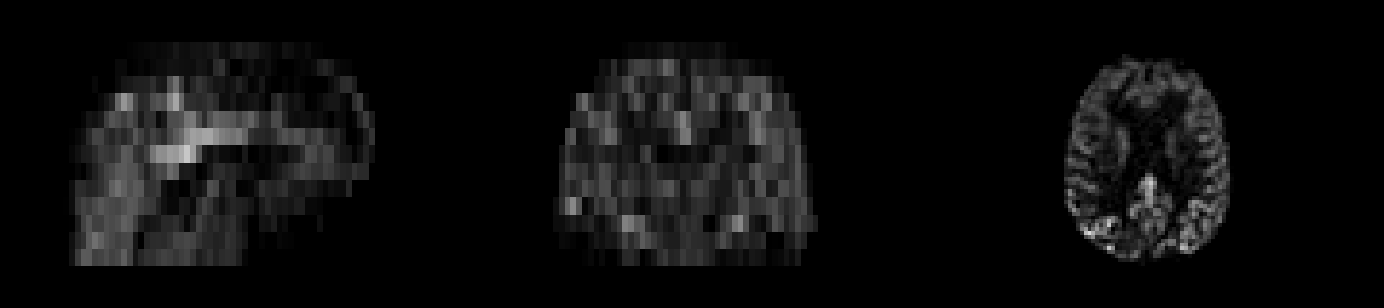


Pefusion with distortion correction
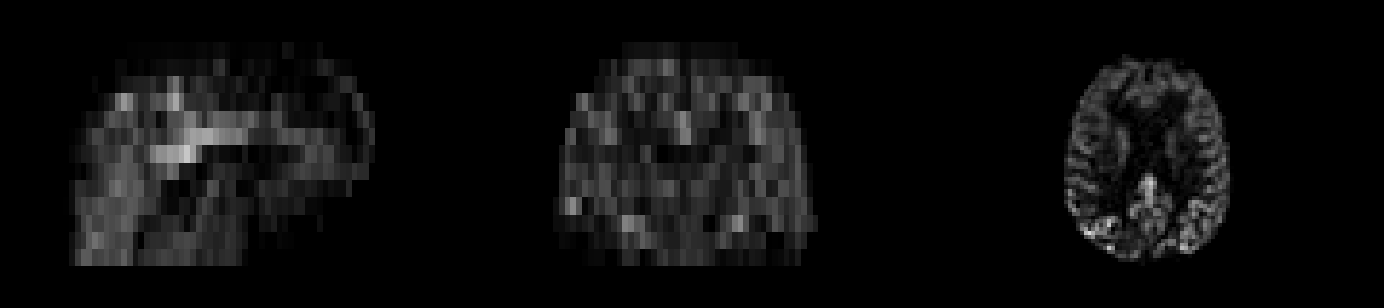


<br>
<br>


**Data processed with latest FSL**


Perfusion
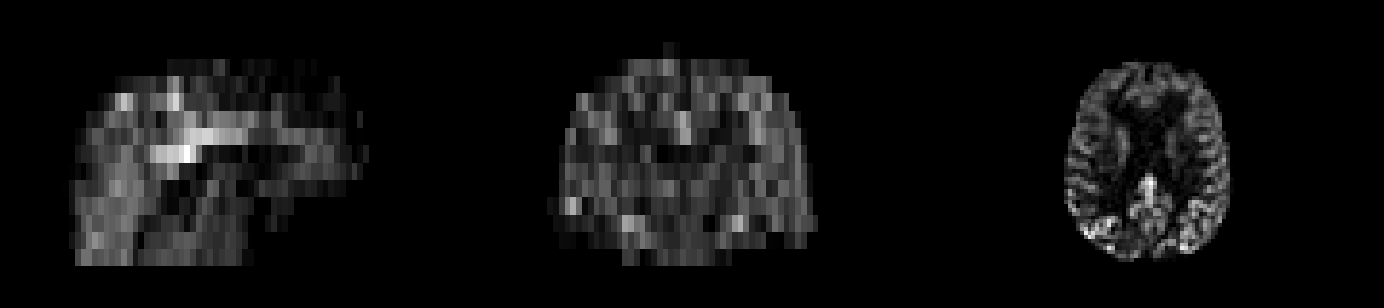


Perfusion with PVC
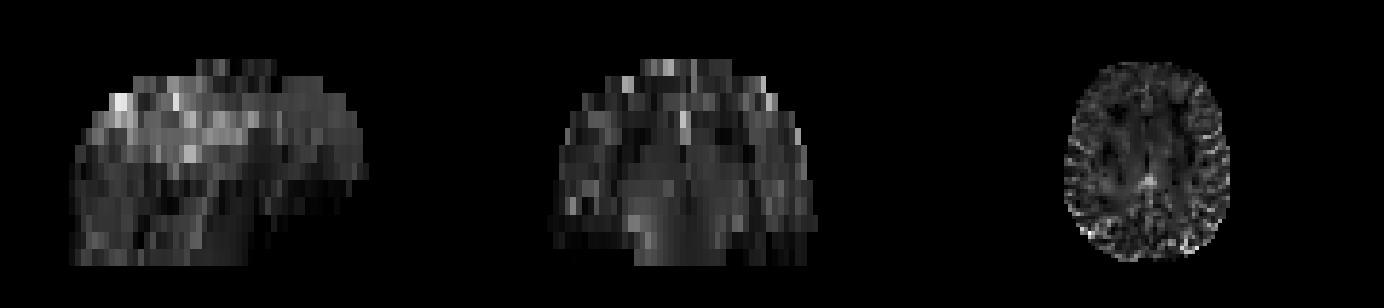


Pefusion with distortion correction
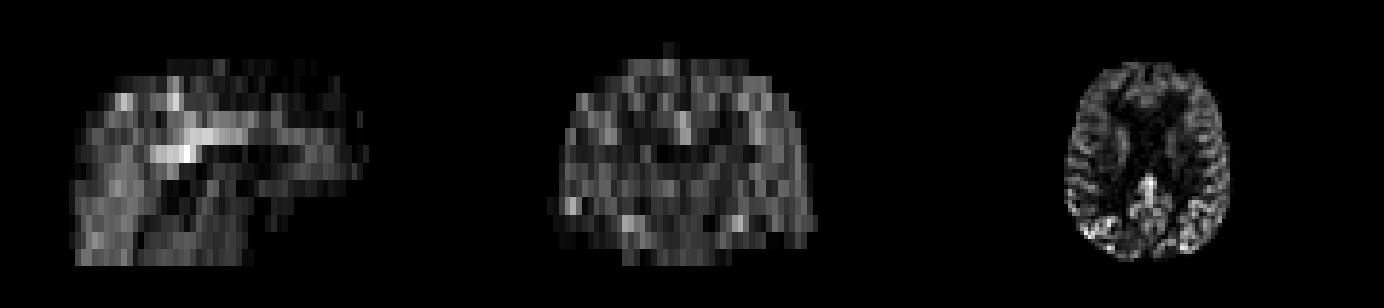


Pefusion with distortion correction and PVC
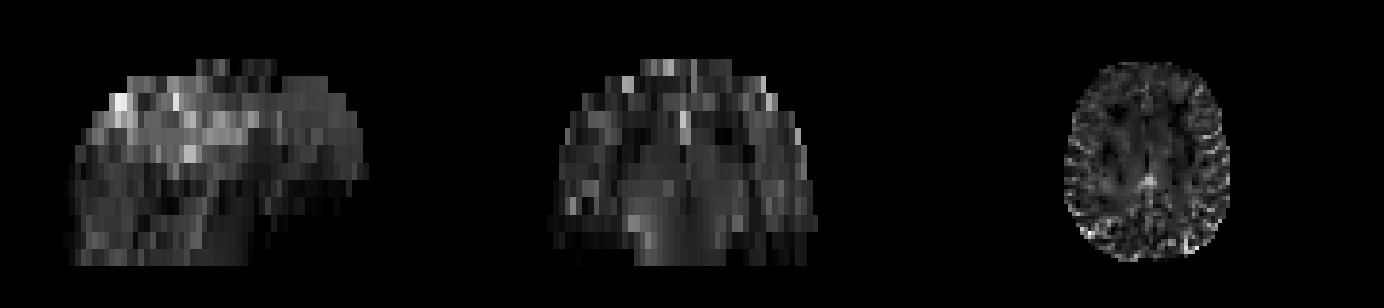

## Data labels


### 34 labeled as outliers out of 558 subjects 
* 26 labeled with Poor labeling
* 6 labeled with Dealyed Arrival
* 7 labeled with Motion
* 1 labeled with Low Contrast
* 1 labeled with Poor Signal


## Outliers examples

**Poor Labelling**  
ID:1271915
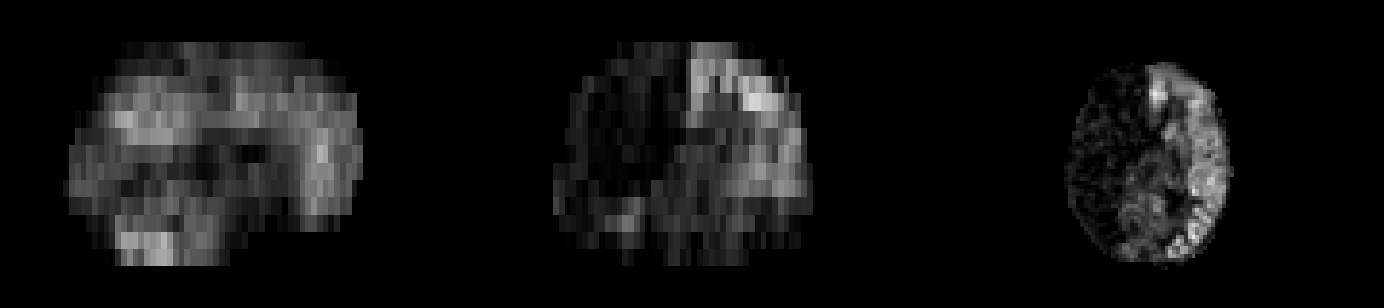



**Poor Labelling & Dealyed Arrival**   
ID:1279736
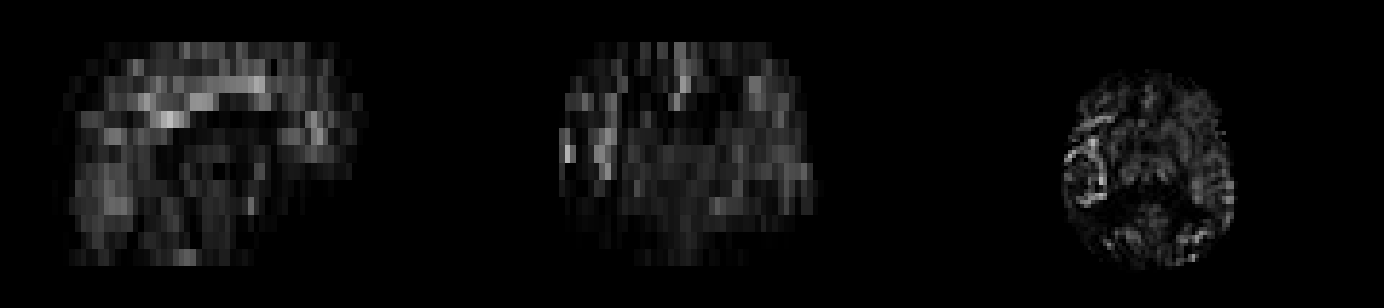



**Motion**  
ID:1333493
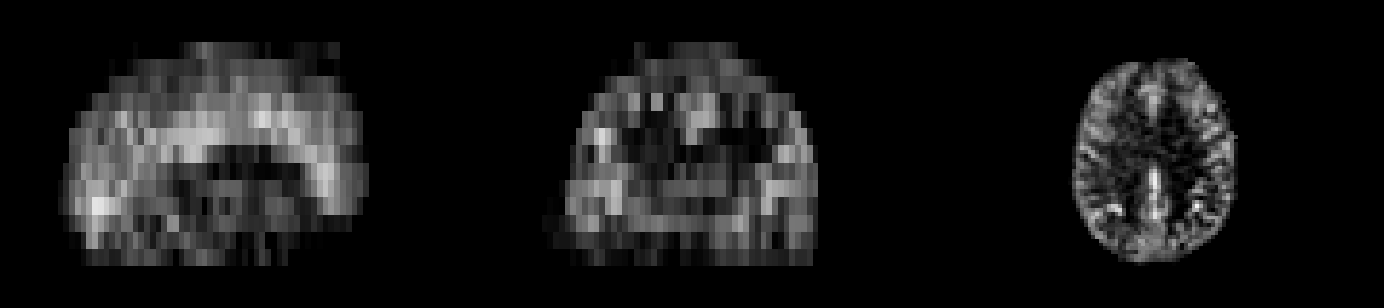  



**Motion & Low Contrast**  
ID:1268351
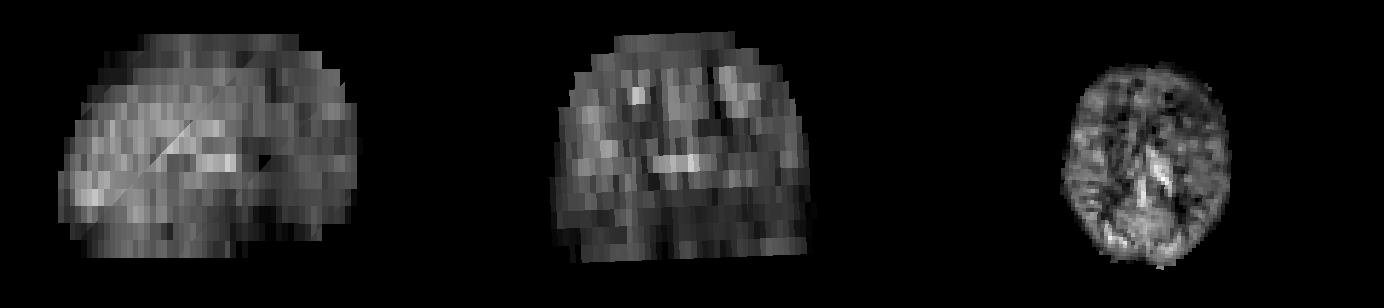



**Poor Labelling & Poor Signal**   
ID:1297025
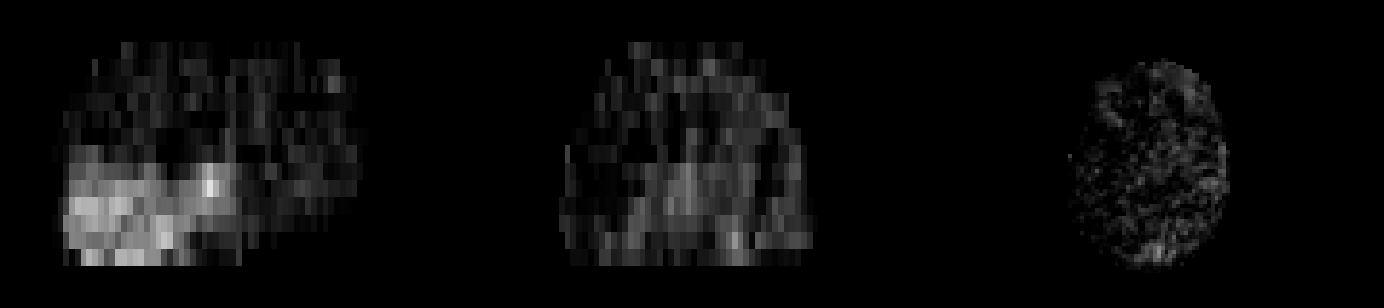

# Quality Control Metrics

## ASL 
1. GM & WM Perfusion 
2. Spatial Coefficient of Variance(SCoV)
3. Coefficient of joint variance between GM & WM
4. GM & WM Perfsion on territories

## Registration
1. Sum of squared differences
2. Cross-Correlation
3. Pearson Correlation Coefficient
4. Mutual Information
5. Normalized Mutual Information
6. Correlation ratio


# BRC pipeline

## T1
* Cropping(optional) [robustfov] 
* Brain extraction [BET]
* Reduce FOV->T1 [standard_space_roi]
* Register to std(linear) [FLIRT]
* Register to std(non-linear) [FNIRT]
* Brain extraction->T1_brain_mask
* Defaceing
* Bias-field correction->T1_brain_bias [FAST]
* Tissue segmentation->pve
* Subcortical segmentation [run_first_all] 

## ASL
1. Register ASL to T1 [FLIRT]
2. Partial Volume Correction(Liang et al, DOI: 10.1002/mrm.24279)
3. Register ASL to standard space from T1